In [342]:
# Standard library
import os
import functools
from collections import defaultdict
from itertools import combinations

# Third-party
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco
from scipy.stats import wasserstein_distance
from scipy.sparse import coo_matrix, csr_matrix, issparse
from scipy.sparse.linalg import eigsh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torchmetrics.regression import MeanAbsolutePercentageError
from typing import Dict, List, Tuple, Optional, Any


# # Set up device (is available use GPU to speed up computations)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# os.chdir('/home/jovyan/dlss-project')
# print("Current working directory:", os.getcwd())

In [343]:
path_geo_edges = "../data_collection/geography/edges_yearly_dist_enc.parquet"
path_geo_nodes = "../data_collection/geography/nodes_enc.parquet"
df_geo_edges = pd.read_parquet(path_geo_edges)
df_geo_nodes = pd.read_parquet(path_geo_nodes)

path_pol_edges = "../data_collection/political/data/edge_features.parquet"
path_pol_nodes = "../data_collection/political/data/node_features.parquet"
df_pol_edges = pd.read_parquet(path_pol_edges)
df_pol_nodes = pd.read_parquet(path_pol_nodes)

path_cult_edges = "../data_collection/culture/culture_edges.parquet"
path_cult_nodes = "../data_collection/culture/culture_nodes.parquet"
df_cult_edges = pd.read_parquet(path_cult_edges)
df_cult_nodes = pd.read_parquet(path_cult_nodes)

path_lang_edges = "../data_collection/culture/language_religion_edges.parquet"
path_lang_nodes = "../data_collection/culture/language_religion_nodes.parquet"
df_lang_edges = pd.read_parquet(path_lang_edges)
df_lang_nodes = pd.read_parquet(path_lang_nodes)

path_eco_edges = "../data_collection/economics/edges_economics.parquet"
path_eco_nodes = "../data_collection/economics/nodes_economics.parquet"
df_eco_edges = pd.read_parquet(path_eco_edges)
df_eco_nodes = pd.read_parquet(path_eco_nodes)

path_gini = "../data_collection/gini.parquet"
df_gini = pd.read_parquet(path_gini)
df_gini = df_gini[df_gini['year'].between(2000, 2022)].reset_index(drop=True)

In [344]:
@functools.lru_cache(maxsize=1)
def get_un_countries():
    """Cache UN member countries to avoid repeated lookups"""
    iso3 = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['ISO3'].dropna().tolist()
    unnumeric = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['UNcode'].dropna().tolist()
    return iso3, unnumeric

@functools.lru_cache(maxsize=1000)
def convert_country_code(country, target_format='UNnumeric'):
    """Cache country code conversions"""
    return coco.convert(names=country, to=target_format, not_found=None)

def df_preparation(edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col="year"):
    # Get UN countries once
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Pre-filter dataframes
    edge_mask = edge_df[edge_country_a_col].isin(uno_iso3_codes) & edge_df[edge_country_b_col].isin(uno_iso3_codes)
    node_mask = node_df[node_country_col].isin(uno_iso3_codes)

    edge_df = edge_df[edge_mask].copy()
    node_df = node_df[node_mask].copy()

    # Ensure year is int before unique extraction
    edge_df[year_col] = edge_df[year_col].astype(int)
    node_df[year_col] = node_df[year_col].astype(int)

    # Vectorized country code conversion
    unique_countries_edges = pd.concat([edge_df[edge_country_a_col], edge_df[edge_country_b_col]]).unique()
    unique_countries_nodes = node_df[node_country_col].unique()
    all_unique_countries = np.unique(np.concatenate([unique_countries_edges, unique_countries_nodes]))

    country_to_id_map = dict(zip(
        all_unique_countries,
        coco.convert(all_unique_countries.tolist(), to='UNnumeric', not_found=None)
    ))

    # Apply mapping
    edge_df['country_id_a'] = edge_df[edge_country_a_col].map(country_to_id_map)
    edge_df['country_id_b'] = edge_df[edge_country_b_col].map(country_to_id_map)
    node_df['country_id'] = node_df[node_country_col].map(country_to_id_map)

    # Drop any rows where mapping failed (shouldn't if filters were correct)
    edge_df = edge_df.dropna(subset=['country_id_a', 'country_id_b'])
    node_df = node_df.dropna(subset=['country_id'])

    # Cast country_id to int
    edge_df['country_id_a'] = edge_df['country_id_a'].astype(int)
    edge_df['country_id_b'] = edge_df['country_id_b'].astype(int)
    node_df['country_id'] = node_df['country_id'].astype(int)
    
    edge_features_cols = [
        col for col in edge_df.columns
        if col not in [edge_country_a_col, edge_country_b_col, year_col, 'country_id_a', 'country_id_b']
    ]
    node_features_cols = [
        col for col in node_df.columns
        if col not in [node_country_col, year_col, 'country_id']
    ]
    
    edge_df_processed = edge_df.copy()[['country_id_a', 'country_id_b', year_col] + edge_features_cols]
    node_df_processed = node_df.copy()[['country_id', year_col] + node_features_cols]
    
    return node_df_processed, edge_df_processed

def preprocess_gini(df_gini, year_col='year', country_col='country', gini_col='gini'):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Filter Gini data for UN countries
    df_gini = df_gini[df_gini[country_col].isin(uno_iso3_codes)].copy()
    
    # Convert country codes to UN numeric
    df_gini['country_id'] = df_gini[country_col].map(lambda x: convert_country_code(x, 'UNnumeric'))
    
    df_gini = df_gini.sort_values(by=['country_id']).reset_index(drop=True)
    
    # Drop rows with NaN country_id
    df_gini = df_gini.dropna(subset=['country_id'])
    
    # Normalize Gini values to [0, 1] range for each year
    df_gini[gini_col] = df_gini[gini_col] / 100
    
    # create mask column to indicate if country exists in this year
    df_gini['exists'] = 1
    df_gini.loc[df_gini[gini_col].isna(), 'exists'] = 0
    
    df_gini.loc[df_gini[gini_col].isna(), gini_col] = 0  # Fill NaN Gini values with 0
    
    return df_gini[['country_id', year_col, gini_col, 'exists']].copy()

def create_data_yearly(node_df, edge_df, year, mask_col, year_col='year',):
        
    edge_df_year = edge_df[edge_df[year_col] == year]
    node_df_year = node_df[node_df[year_col] == year].copy()  # copy because we'll potentially modify
    
    # drop dupicate rows in node_df_year
    node_df_year = node_df_year.drop_duplicates(subset=['country_id', year_col], keep='first')
            
    # --- Edge features ---
    edge_features_cols = [
        col for col in edge_df_year.columns
        if col not in ['country_id_a', 'country_id_b', year_col]
    ]
    edge_features_df = edge_df_year[edge_features_cols].copy()
    
    # Coerce all edge feature columns to numeric, fill NaN with 0
    edge_features_df = edge_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # --- Node features ---
    node_features_cols = [
        col for col in node_df_year.columns
        if col not in ['country_id', year_col, mask_col]
    ]
    # TODO: maybe also remove 'exists' column
        
    # Ensure node_df_year is sorted by country_id and align features accordingly
    node_df_year_sorted = node_df_year.sort_values(by='country_id').reset_index(drop=True)
        
    # select only feature columns
    node_df_year_features = node_df_year_sorted[node_features_cols].copy()
    
    mask_col_tensor = torch.tensor(node_df_year_sorted[mask_col].values, dtype=torch.float32)
    
    country_id_tensor = torch.tensor(node_df_year_sorted['country_id'].values, dtype=torch.long)
    
    # --- Tensor creation ---
    edge_features_array = edge_features_df.values.astype(np.float32)
    edge_attr = torch.from_numpy(edge_features_array)

    
    node_df_year_features = node_df_year_features.apply(pd.to_numeric, errors='coerce').fillna(0)
    node_features_tensor = torch.tensor(node_df_year_features.values, dtype=torch.float32)
    
    
    # Build a mapping from country_id to its position in the sorted node list
    country_id_to_pos = {cid: i for i, cid in enumerate(node_df_year_sorted['country_id'].values)}
    
    # Map edge indices to positions in the sorted node list
    edge_index = torch.tensor(
        [
        edge_df_year['country_id_a'].map(country_id_to_pos).values,
        edge_df_year['country_id_b'].map(country_id_to_pos).values
        ],
        dtype=torch.long
    )
    data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, country_id = country_id_tensor, mask=mask_col_tensor)
    
    return data

def scale_data(node_df, edge_df, node_features_cols, edge_feature_cols):
    """
    Scale node and edge dataframes using StandardScaler.
    """
    # apply standardization to node features
    node_scaler = StandardScaler()
    edge_scaler = StandardScaler()
    
    # fit standard scaler on train set
    
    # create subset of only training rows to fit scaler
    node_df_train_subset = node_df[node_df['train_mask'] == 1]
    node_scaler.fit(node_df_train_subset[node_features_cols])
    
    # filter edge_df to only include training countries
    edge_df_train_subset = edge_df[edge_df['country_id_a'].isin(node_df_train_subset['country_id']) & 
                                   edge_df['country_id_b'].isin(node_df_train_subset['country_id'])]
    edge_scaler.fit(edge_df_train_subset[edge_feature_cols])
    
    # apply scaler to all node dataframes
    node_df[node_features_cols] = node_scaler.transform(node_df[node_features_cols])
    edge_df[edge_feature_cols] = edge_scaler.transform(edge_df[edge_feature_cols])
    
    return node_df, edge_df

def create_network_data(node_df, edge_df, gini_df):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()
    
    # convert boolean columns to int
    bool_cols_nodes = node_df.select_dtypes(include='bool').columns
    if len(bool_cols_nodes) > 0:
        node_df[bool_cols_nodes] = node_df[bool_cols_nodes].astype(int)
    bool_cols_edges = edge_df.select_dtypes(include='bool').columns
    if len(bool_cols_edges) > 0:
        edge_df[bool_cols_edges] = edge_df[bool_cols_edges].astype(int)
    
    # fill in all missing countries with 0 values for the years from 2000 to 2022
    all_years = range(2000, 2023)
    all_countries = uno_unnumeric_codes
    
    # Create a MultiIndex of all combinations
    full_index = pd.MultiIndex.from_product([all_countries, all_years], names=['country_id', 'year'])
    node_df = node_df.set_index(['country_id', 'year'])
    node_df = node_df.reindex(full_index, fill_value=0).reset_index()
        
    # Fill missing feature columns with 0 (if any NaNs)
    node_features_cols = [col for col in node_df.columns if col not in ['country_id', 'year']]
    node_df[node_features_cols] = node_df[node_features_cols].fillna(0)
    
    edge_feature_cols = [col for col in edge_df.columns if col not in ['country_id_a', 'country_id_b', 'year']]
    
    # merge node_df with gini_df
    node_df_merged = node_df.merge(gini_df, on=['country_id', 'year'])
    
    node_df_merged, edge_df = scale_data(node_df_merged, edge_df, node_features_cols, edge_feature_cols)
    
    # generate train, val and test set.
    # set gini to 0 at respected masks
    
    node_df_train = node_df_merged.copy().drop(columns=['val_mask', 'test_mask'], errors='ignore')
    node_df_val = node_df_merged.copy().drop(columns=['train_mask', 'test_mask'], errors='ignore')
    node_df_test = node_df_merged.copy().drop(columns=['train_mask', 'val_mask'], errors='ignore')
    
    # set gini to 0 where train_mask is 1
    node_df_train.loc[gini_df['train_mask'] == 1, 'gini'] = 0
    node_df_val.loc[gini_df['val_mask'] == 1, 'gini'] = 0
    node_df_test.loc[gini_df['test_mask'] == 1, 'gini'] = 0
    
    
    # limit years from 2000 to 2022
    years = [year for year in range(2000, 2023)]
    
    data_dict = {}
    # create data for each year
    
    for year in years:
        data_train = create_data_yearly(node_df_train, edge_df, year, 'train_mask', year_col='year')
        data_val = create_data_yearly(node_df_val, edge_df, year, 'val_mask', year_col='year')
        data_test = create_data_yearly(node_df_test, edge_df, year, 'test_mask', year_col='year')
        data_dict[year] = {
            'train': data_train,
            'val': data_val,
            'test': data_test
        }
    
    return data_dict

def create_gini_data(gini_df, year_col='year'):
    
    gini_dict = {}
    
    for year in range(2000, 2023):
        gini_df_year = gini_df[gini_df[year_col] == year].copy()

        # convert to tensor
        gini_tensor = torch.tensor(gini_df_year['gini'].values, dtype=torch.float32)
        country_id_tensor = torch.tensor(gini_df_year['country_id'].values, dtype=torch.long)
        train_mask_tensor = torch.tensor(gini_df_year['train_mask'].values, dtype=torch.bool)
        val_mask_tensor = torch.tensor(gini_df_year['val_mask'].values, dtype=torch.bool)
        test_mask_tensor = torch.tensor(gini_df_year['test_mask'].values, dtype=torch.bool)
        
        
        
        gini_dict[year] = {
            'train': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=train_mask_tensor),
            'val': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=val_mask_tensor),
            'test': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=test_mask_tensor)
        }
        
    return gini_dict
            

def create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split all available (exists==1) rows in gini_df into train/val/test and create mask columns.
    Adds 'train_mask', 'val_mask', 'test_mask' columns to gini_df (0/1 values).
    """
    df = gini_df.copy()
    available_idx = df.index[df['exists'] == 1].tolist()
    train_idx, test_idx = train_test_split(available_idx, test_size=test_size, random_state=random_state)
    train_idx, val_idx = train_test_split(train_idx, test_size=val_size, random_state=random_state)
    
    df['train_mask'] = 0
    df['val_mask'] = 0
    df['test_mask'] = 0
    df.loc[train_idx, 'train_mask'] = 1
    df.loc[val_idx, 'val_mask'] = 1
    df.loc[test_idx, 'test_mask'] = 1
    return df

def create_data(data_combined, gini_df):
    
    # create gini train, val and test masks
    # perform train-val-test split on gini_data for all available values
    
    gini_df = create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42)
    
    data_dict = {}
    
    for modality, data in data_combined.items():
        nodes = data['nodes']
        edges = data['edges']
        data_dict[modality] = create_network_data(nodes, edges, gini_df)
        
    # add gini data
    gini_data = create_gini_data(gini_df)
    data_dict['gini'] = gini_data
    
    data_dict_reform = {}
    # reform data_dict to have years as keys
    for year in range(2000, 2023):
        data_dict_reform[year] = {
            'political': data_dict['political'][year],
            'geography': data_dict['geography'][year],
            'culture': data_dict['culture'][year],
            'language': data_dict['language'][year],
            'economy': data_dict['economy'][year],
            'gini': gini_data[year]
        }
    
    # reform again to have train, val, test as subkeys -> data_dict_reform[year]['train'], data_dict_reform[year]['val'], data_dict_reform[year]['test']
    for year in data_dict_reform.keys():
        data_dict_reform[year] = {
            'train': {
                'political': data_dict_reform[year]['political']['train'],
                'geography': data_dict_reform[year]['geography']['train'],
                'culture': data_dict_reform[year]['culture']['train'],
                'language': data_dict_reform[year]['language']['train'],
                'economy': data_dict_reform[year]['economy']['train'],
                'gini': data_dict_reform[year]['gini']['train']
            },
            'val': {
                'political': data_dict_reform[year]['political']['val'],
                'geography': data_dict_reform[year]['geography']['val'],
                'culture': data_dict_reform[year]['culture']['val'],
                'language': data_dict_reform[year]['language']['val'],
                'economy': data_dict_reform[year]['economy']['val'],
                'gini': data_dict_reform[year]['gini']['val']
            },
            'test': {
                'political': data_dict_reform[year]['political']['test'],
                'geography': data_dict_reform[year]['geography']['test'],
                'culture': data_dict_reform[year]['culture']['test'],
                'language': data_dict_reform[year]['language']['test'],
                'economy': data_dict_reform[year]['economy']['test'],
                'gini': data_dict_reform[year]['gini']['test']
            }
        }
        
    return data_dict_reform

In [345]:
geo_nodes, geo_edges = df_preparation(df_geo_edges, df_geo_nodes, 
                        edge_country_a_col='iso_o', edge_country_b_col='iso_d',
                        node_country_col='code_3', year_col='year')

pol_nodes, pol_edges = df_preparation(df_pol_edges, df_pol_nodes,
                        edge_country_a_col='state1', edge_country_b_col='state2',
                        node_country_col='country', year_col='year')

cul_nodes, cul_edges = df_preparation(df_cult_edges, df_cult_nodes,
                        edge_country_a_col='ISO3_a', edge_country_b_col='ISO3_b',
                        node_country_col='ISO3', year_col='year')

lang_nodes, lang_edges = df_preparation(df_lang_edges, df_lang_nodes,
                        edge_country_a_col='country_a', edge_country_b_col='country_b',
                        node_country_col='ISO3', year_col='year')

eco_nodes, eco_edges = df_preparation(df_eco_edges, df_eco_nodes,
                        edge_country_a_col='src_ISO3', edge_country_b_col='tgt_ISO3',
                        node_country_col='ISO3', year_col='year')

In [346]:
edges=[geo_edges, pol_edges, cul_edges, lang_edges, eco_edges]
nodes=[geo_nodes, pol_nodes, cul_nodes, lang_nodes, eco_nodes]

for i in range(len(edges)):
    edges[i] = edges[i][(edges[i]["year"] >= 2000) & (edges[i]["year"] <= 2022)]

for i in range(len(nodes)):
    nodes[i] = nodes[i][(nodes[i]["year"] >= 2000) & (nodes[i]["year"] <= 2022)]

### Country Similarity

In [347]:
CONFIG = {
    "src_col": "country_id_a",
    "dst_col": "country_id_b",
    "year_col": "year",
    "node_col": "country_id",
    "layer_names": ["geographic", "political", "cultural", "language", "economic"],
    # Similarity metrics
    "struct_metric": "cosine",   # "jaccard" or "cosine" (neighborhood-based)
    "feat_metric": "cosine",      # used for node/edge feature vectors
     # Component weights within a layer
    "alpha_struct": 0.5,
    "alpha_node": 0.25,
    "alpha_edgefeat": 0.25,
    # How to combine multiple edge numeric features into structural similarity
    # "sum" = sum the weighted-adjacency cosine sims; "mean" = average them
    "edge_weight_combine": "mean",
    # Whether to include unweighted structural similarity alongside weighted ones
    "include_unweighted_struct": True,
}


In [348]:


# =========================
# Utilities
# =========================
def _ensure_list(x, expected_len=None):
    assert isinstance(x, (list, tuple)), "Expected a list/tuple."
    if expected_len is not None:
        assert len(x) == expected_len, f"Expected list length {expected_len}, got {len(x)}"
    return x


def _build_node_index(nodes):
    nodes_sorted = sorted(nodes)
    return {n: i for i, n in enumerate(nodes_sorted)}, nodes_sorted

def _detect_feature_types(df: pd.DataFrame, exclude: List[str]) -> Tuple[List[str], List[str]]:
    cols = [c for c in df.columns if c not in exclude]
    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in cols if c not in num_cols]
    return num_cols, cat_cols

def _zscore(df: pd.DataFrame) -> pd.DataFrame:
    # per-column z-score; robust to 0 var
    out = df.copy()
    for c in out.columns:
        s = out[c]
        mu = s.mean()
        sd = s.std(ddof=0)
        if sd and np.isfinite(sd) and sd > 0:
            out[c] = (s - mu) / sd
        else:
            out[c] = 0.0
    return out

def _one_hot(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    if not cols:
        return pd.DataFrame(index=df.index)
    # limit explosion by dropping high-cardinality text columns if needed
    return pd.get_dummies(df[cols].astype("category"), dummy_na=False)

def _align_matrix(rows_index: List[str], target_index: List[str], M: np.ndarray, fill=0.0) -> np.ndarray:
    """Align square matrix M (rows_index order) into target_index order."""
    idx_map = {n: i for i, n in enumerate(rows_index)}
    N = len(target_index)
    out = np.full((N, N), fill, dtype=np.float32)
    for i, ni in enumerate(target_index):
        ii = idx_map.get(ni, None)
        if ii is None:
            continue
        for j, nj in enumerate(target_index):
            jj = idx_map.get(nj, None)
            if jj is None:
                continue
            out[i, j] = M[ii, jj]
    return out


def _cosine_sim(X: np.ndarray) -> np.ndarray:
    if X.size == 0:
        return np.zeros((0,0), dtype=np.float32)
    # L2 normalize rows, then S = X X^T
    Xn = X.copy()
    norms = np.linalg.norm(Xn, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    Xn = Xn / norms
    S = (Xn @ Xn.T).astype(np.float32)
    np.fill_diagonal(S, 1.0)
    return S



In [349]:
# =========================
# Build adjacency variants
# =========================
def _adjacency_variants(edge_df: pd.DataFrame, node_list: List[str], cfg: Dict) -> Tuple[csr_matrix, Dict[str, csr_matrix]]:
    """Return unweighted adjacency and a dict of weighted adjacencies for each numeric edge feature."""
    src, dst = cfg["src_col"], cfg["dst_col"]
    idx, nodes_sorted = _build_node_index(node_list)
    n = len(nodes_sorted)
    # unweighted
    rows, cols = [], []
    for s, t in zip(edge_df[src].values, edge_df[dst].values):
        if s in idx and t in idx:
            i, j = idx[s], idx[t]
            rows += [i, j]
            cols += [j, i]
    data = np.ones(len(rows), dtype=np.float32)
    A = csr_matrix((data, (rows, cols)), shape=(n, n), dtype=np.float32)
    A.setdiag(0); A.eliminate_zeros()

    # weighted by numeric edge features
    exclude = [src, dst, cfg["year_col"]]
    num_cols, _ = _detect_feature_types(edge_df, exclude)
    weighted = {}
    for c in num_cols:
        r, co, d = [], [], []
        vals = edge_df[c].astype(float).fillna(0.0).values
        for (s, t), w in zip(zip(edge_df[src].values, edge_df[dst].values), vals):
            if s in idx and t in idx:
                i, j = idx[s], idx[t]
                if w != 0 and np.isfinite(w):
                    r += [i, j]; co += [j, i]; d += [w, w]
        W = csr_matrix((np.array(d, dtype=np.float32), (r, co)), shape=(n, n), dtype=np.float32)
        W.setdiag(0); W.eliminate_zeros()
        if W.nnz:
            weighted[c] = W
    return A, weighted


In [350]:
# =========================
# Structural similarity
# =========================
def _structural_similarity(A: csr_matrix, W_dict: Dict[str, csr_matrix], metric: str, include_unweighted: bool, combine_op: str) -> Dict[str, np.ndarray]:
    """
    Returns dict with keys:
      'unweighted' (optional), and each weighted feature name -> similarity matrix
    """
    out = {}
    if A.shape[0] == 0:
        return out

    def neigh_sim(M: csr_matrix, metric: str) -> np.ndarray:
        if metric == "cosine":
            X = normalize(M, norm='l2', axis=1, copy=False)
            S = (X @ X.T).toarray().astype(np.float32)
            np.fill_diagonal(S, 1.0)
            return S
        elif metric == "jaccard":
            # common neighbors
            C = (M @ M.T).astype(np.float32).toarray()
            deg = np.asarray(M.sum(axis=1)).ravel()
            U = deg[:,None] + deg[None,:] - C
            with np.errstate(divide='ignore', invalid='ignore'):
                S = np.where(U > 0, C / U, 0.0).astype(np.float32)
            np.fill_diagonal(S, 1.0)
            return S
        else:
            raise ValueError("metric must be 'jaccard' or 'cosine'")

    if include_unweighted:
        out["unweighted"] = neigh_sim(A, metric)

    for feat, W in W_dict.items():
        # for weighted adjacency, cosine generally makes more sense than jaccard
        out[f"weighted::{feat}"] = neigh_sim(W, "cosine")

    # Optionally combine all structural pieces into one matrix
    keys = list(out.keys())
    if not keys:
        return {}
    stack = np.stack([out[k] for k in keys], axis=0)
    if combine_op == "sum":
        out["struct_all"] = stack.sum(axis=0) / stack.shape[0]
    else:  # mean
        out["struct_all"] = stack.mean(axis=0)
    return out

In [351]:
# =========================
# Node-feature similarity
# =========================
def _node_feature_similarity(node_df: pd.DataFrame, nodes_order: List[str], cfg: Dict) -> Optional[np.ndarray]:
    if node_df is None or node_df.empty or len(nodes_order) == 0:
        return None
    id_col, year_col = cfg["node_col"], cfg["year_col"]
    # restrict to available nodes
    node_df = node_df[node_df[id_col].isin(nodes_order)].copy()
    if node_df.empty:
        return None
    # detect features
    exclude = [id_col, year_col]
    num_cols, cat_cols = _detect_feature_types(node_df, exclude)
    # build feature matrix
    parts = []
    if num_cols:
        parts.append(_zscore(node_df[num_cols].astype(float)).fillna(0.0))
    if cat_cols:
        parts.append(_one_hot(node_df, cat_cols))
    if not parts:
        return None
    X = pd.concat(parts, axis=1)
    # align to nodes_order
    X = X.reindex(node_df[id_col], axis=0)
    X.index = node_df[id_col].values
    X = X.reindex(nodes_order, axis=0).fillna(0.0)
    return _cosine_sim(X.values.astype(np.float32))

In [352]:
# =========================
# Edge-feature (summary) similarity
# =========================
def _edge_feature_summary_similarity(edge_df: pd.DataFrame, nodes_order: List[str], cfg: Dict) -> Optional[np.ndarray]:
    """
    Build per-node summaries of edge numeric features: sum of incident weights per feature,
    plus degree. Cosine similarity over these summaries.
    """
    if edge_df is None or edge_df.empty or len(nodes_order) == 0:
        return None
    src, dst = cfg["src_col"], cfg["dst_col"]
    exclude = [src, dst, cfg["year_col"]]
    num_cols, cat_cols = _detect_feature_types(edge_df, exclude)
    cols = ["degree"] + num_cols  # degree always included

    # Init summary
    S = pd.DataFrame(0.0, index=nodes_order, columns=cols)
    # degree
    deg_counts = pd.concat([edge_df[src], edge_df[dst]]).value_counts()
    for node, val in deg_counts.items():
        if node in S.index:
            S.loc[node, "degree"] = float(val)

    # numeric edge-feat strength (sum of incident weights)
    for c in num_cols:
        e = edge_df[[src, dst, c]].copy()
        e[c] = pd.to_numeric(e[c], errors='coerce').fillna(0.0)
        contrib = e.groupby(src)[c].sum().add(e.groupby(dst)[c].sum(), fill_value=0.0)
        for node, val in contrib.items():
            if node in S.index:
                S.loc[node, c] = float(val)

    # categorical edges (optional): count per category -> one-hot columns
    # (enable if you have a few categories and want them)
    if cat_cols:
        # Build category counts per node per categorical column
        for c in cat_cols:
            # count categories on incident edges
            cat_counts_src = edge_df.groupby([src, c]).size().unstack(fill_value=0)
            cat_counts_dst = edge_df.groupby([dst, c]).size().unstack(fill_value=0)
            cat_counts = cat_counts_src.add(cat_counts_dst, fill_value=0)
            # keep only few top categories to avoid explosion
            if cat_counts.shape[1] > 20:
                topk = cat_counts.sum().nlargest(20).index
                cat_counts = cat_counts[topk]
            # align and add
            cat_counts = cat_counts.reindex(S.index, fill_value=0)
            # prepend column name to avoid clashes
            cat_counts = cat_counts.add_prefix(f"{c}=")
            S = pd.concat([S, cat_counts], axis=1)

    # standardize numeric‑ish columns (safe z-score)
    S = _zscore(S)

    return _cosine_sim(S.values.astype(np.float32))

In [353]:
# =========================
# Orchestration: build per-layer/year similarities
# =========================
def build_layer_year_similarities(edges_list: List[pd.DataFrame],
                                  nodes_list: Optional[List[pd.DataFrame]],
                                  cfg: Dict = CONFIG):
    edges_list = _ensure_list(edges_list, expected_len=len(cfg["layer_names"]))
    if nodes_list is None:
        nodes_list = [None] * len(edges_list)
    else:
        nodes_list = _ensure_list(nodes_list, expected_len=len(cfg["layer_names"]))

    result = defaultdict(dict)  # result[layer][year] = {"S": ndarray, "nodes": [...]}

    for ell, layer in enumerate(cfg["layer_names"]):
        e_df = edges_list[ell]
        n_df = nodes_list[ell]
        year_col = cfg["year_col"]
        for year, e_year in e_df.groupby(year_col):
            # union of nodes seen in edges and (optionally) nodes df
            nodes_set = set(e_year[cfg["src_col"]]).union(e_year[cfg["dst_col"]])
            if n_df is not None and not n_df.empty:
                nodes_set |= set(n_df[n_df[year_col] == year][cfg["node_col"]])
            nodes_order = sorted(nodes_set)
            if not nodes_order:
                continue

            # Adjacency variants
            A, W_dict = _adjacency_variants(e_year, nodes_order, cfg)
            struct_parts = _structural_similarity(
                A, W_dict,
                metric=cfg["struct_metric"],
                include_unweighted=cfg["include_unweighted_struct"],
                combine_op=cfg["edge_weight_combine"],
            )
            S_struct = struct_parts.get("struct_all", None)

            # Node features
            n_year = None
            if n_df is not None and not n_df.empty:
                n_year = n_df[n_df[year_col] == year].copy()
            S_node = _node_feature_similarity(n_year, nodes_order, cfg)

            # Edge feature summaries
            S_edgefeat = _edge_feature_summary_similarity(e_year, nodes_order, cfg)

            # Combine available components
            parts = []
            weights = []
            if S_struct is not None:
                parts.append(S_struct); weights.append(cfg["alpha_struct"])
            if S_node is not None:
                parts.append(S_node); weights.append(cfg["alpha_node"])
            if S_edgefeat is not None:
                parts.append(S_edgefeat); weights.append(cfg["alpha_edgefeat"])

            if not parts:
                # fall back to unweighted structure if everything missing
                parts = [np.eye(len(nodes_order), dtype=np.float32)]
                weights = [1.0]

            w = np.array(weights, dtype=np.float32)
            w = w / (w.sum() if w.sum() > 0 else 1.0)
            S_layer = np.tensordot(w, np.stack(parts, axis=0), axes=(0,0)).astype(np.float32)

            result[layer][int(year)] = {"S": S_layer, "nodes": nodes_order}

    return result

In [354]:
# =========================
# Fusion across layers (within year)
# =========================

def fuse_layers_within_year(S_by_layer: Dict[str, Dict[int, Dict[str, Any]]],
                            layer_weights: Optional[Dict[str, float]] = None):
    layers = list(S_by_layer.keys())
    if layer_weights is None:
        layer_weights = {layer: 1.0 for layer in layers}
    # normalize
    tw = sum(layer_weights.values())
    layer_weights = {k: v/tw for k, v in layer_weights.items()}

    years = sorted(set().union(*[set(S_by_layer[layer].keys()) for layer in layers]))
    fused = {}
    for y in years:
        sims, node_lists, wts = [], [], []
        for layer in layers:
            if y in S_by_layer[layer]:
                sims.append(S_by_layer[layer][y]["S"])
                node_lists.append(S_by_layer[layer][y]["nodes"])
                wts.append(layer_weights[layer])
        if not sims:
            continue
        # align to union of nodes
        node_union = sorted(set().union(*map(set, node_lists)))
        aligned = []
        for S, nodes in zip(sims, node_lists):
            aligned.append(_align_matrix(nodes, node_union, S, fill=0.0))
        w = np.array(wts, dtype=np.float32)[:, None, None]
        S_y = (w * np.stack(aligned, axis=0)).sum(axis=0)

        # ✅ Ensure self-similarity = 1.0 for all countries
        np.fill_diagonal(S_y, 1.0)

        fused[y] = {"S": S_y.astype(np.float32), "nodes": node_union}
    return fused


In [355]:

# =========================
# Temporal smoothing (across time)
# =========================
def temporal_fuse(fused_by_year: Dict[int, Dict[str, Any]],
                  half_life: float = 2.0,
                  window: Optional[int] = None):
    years = sorted(fused_by_year.keys())
    if not years:
        return {}
    all_nodes = sorted(set().union(*[set(v["nodes"]) for v in fused_by_year.values()]))
    N = len(all_nodes)

    # pre‑align each year's matrix to the union of nodes
    aligned = {
        y: _align_matrix(fused_by_year[y]["nodes"], all_nodes, fused_by_year[y]["S"], fill=0.0)
        for y in years
    }

    def decay(dt):  # exponential decay
        return 0.5 ** (abs(dt) / float(half_life))

    smoothed = {}
    for y in years:
        Ys, Ws = [], []
        for yt in years:
            if (window is not None) and (abs(yt - y) > window):
                continue
            wt = decay(yt - y)
            Ys.append(aligned[yt] * wt)
            Ws.append(wt)

        S_sm = np.sum(Ys, axis=0) / (np.sum(Ws) if np.sum(Ws) > 0 else 1.0)

        # ✅ ensure self‑similarity = 1.0 after temporal averaging
        if S_sm.size:
            np.fill_diagonal(S_sm, 1.0)

        smoothed[y] = {"S": S_sm.astype(np.float32), "nodes": all_nodes}

    return smoothed



In [356]:
# =========================
# Convenience: top-k
# =========================
def topk_similar(bundle: Dict[str, Any], country: str, k: int = 10, exclude_self: bool = True):
    S = bundle["S"]; nodes = bundle["nodes"]
    if country not in nodes:
        raise ValueError(f"{country} not found.")
    i = nodes.index(country)
    sims = S[i].copy()
    if exclude_self:
        sims[i] = -np.inf
    order = np.argsort(-sims)[:k]
    return [(nodes[j], float(sims[j])) for j in order]

In [357]:
## Fusing layers together
CONFIG["alpha_struct"] = 0.33
CONFIG["alpha_node"] = 0.33
CONFIG["alpha_edgefeat"] = 0.34


In [358]:
# Build per-layer/year adjacencies
S_by_layer = build_layer_year_similarities(edges, nodes, CONFIG)

In [359]:
top10_political=topk_similar(S_by_layer["economic"][2022],coco.convert("USA", to="UNnumeric"), k=10 )
for country,score in top10_political:
    print(coco.convert(country, to="name_short"),score)

Germany 0.6654990315437317
China 0.6654200553894043
France 0.6647618412971497
United Kingdom 0.6646385192871094
Netherlands 0.6644157767295837
Italy 0.6641082763671875
India 0.6639882922172546
South Korea 0.6639255285263062
Japan 0.6637404561042786
Spain 0.6630980372428894


In [360]:
#
# Fuse across layers (per year)
layer_weights = {
    "geographic": 1.0,
    "political": 1.0,
    "cultural": 1.0,
    "language": 1.0,
    "economic": 1.0,
}

In [361]:

fused_year = fuse_layers_within_year(S_by_layer, layer_weights=layer_weights)

In [362]:

smoothed = temporal_fuse(fused_year, half_life=2, window=5)

In [363]:
# Example: top-10 similar to 'FRA' in year 2012 after temporal fusion
top10_2012_temporal = topk_similar(fused_year[2019], coco.convert("USA", to="UNnumeric"), k=10)
for country,score in top10_2012_temporal:
    print(coco.convert(country, to="name_short"),score)

Canada 0.5836506485939026
United Kingdom 0.5273997783660889
Chile 0.510482907295227
Mexico 0.5026752948760986
Argentina 0.5012624859809875
Colombia 0.49422141909599304
Spain 0.4925882816314697
Germany 0.4499358534812927
Uruguay 0.44382137060165405
Norway 0.43884459137916565


## Visualization

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform



def convert_un_to_iso3(codes):
    return coco.convert(codes, src="UNnumeric", to="ISO3")

def plot_similarity_heatmap_year(fused_year, year, cluster=True, title=None, figsize=(10, 8), tick_fontsize=7):
    bundle = fused_year[year]
    S = bundle["S"].astype(float)
    nodes = bundle["nodes"]
    
    # Convert labels from UN numeric → ISO3
    labels = coco.convert(nodes, src="UNnumeric", to="ISO3")

    order = np.arange(S.shape[0])
    if cluster and S.shape[0] > 2:
        from scipy.cluster.hierarchy import linkage, leaves_list
        from scipy.spatial.distance import pdist
        D = 1.0 - np.clip(S, 0, 1)
        np.fill_diagonal(D, 0.0)
        Z = linkage(pdist(D), method='average')
        order = leaves_list(Z)

    S_ord = S[order][:, order]
    labels_ord = [labels[i] for i in order]

    plt.figure(figsize=figsize)
    im = plt.imshow(S_ord, aspect='auto', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title or f"Country Similarity — {year}")
    plt.xticks(
        ticks=np.arange(len(labels_ord)), 
        labels=labels_ord, 
        rotation=90,          # full vertical
        fontsize=5)
    plt.yticks(
        ticks=np.arange(len(labels_ord)), 
        labels=labels_ord, 
        fontsize=5)
    plt.tight_layout()
    plt.show()



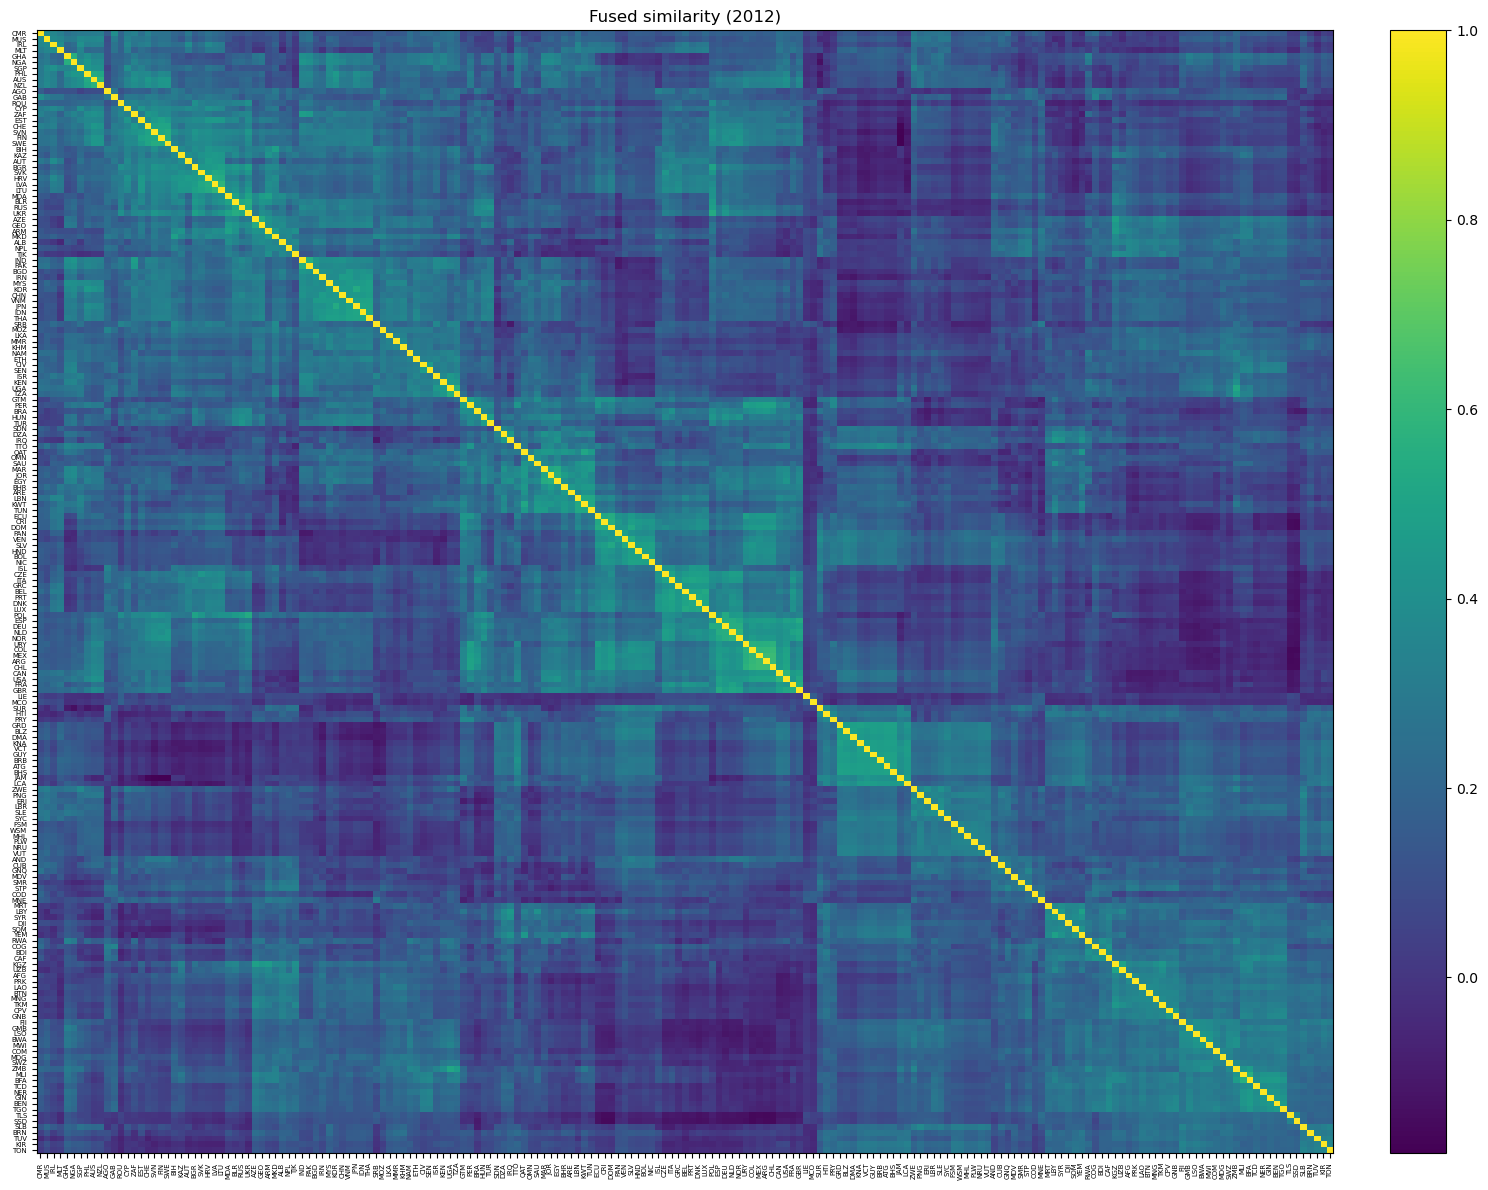

In [365]:
plot_similarity_heatmap_year(smoothed, 2019, cluster=True, title="Fused similarity (2012)", figsize=(15,12))

In [366]:
import numpy as np
import matplotlib.pyplot as plt
import country_converter as coco

import numpy as np
import matplotlib.pyplot as plt
import country_converter as coco

def plot_similarity_subset(bundle, countries, id_type="ISO3",
                           cluster=True, show_every=1, tick_fontsize=7,
                           title=None, figsize=(8, 7)):
    S = bundle["S"].astype(float)
    nodes_raw = bundle["nodes"]
    # index map for fast lookup; include zero-padded aliases
    idx_map = {}
    for i, n in enumerate(nodes_raw):
        s = str(n)
        idx_map[s] = i
        # if numeric-looking, also map zero-padded and int forms
        try:
            iv = int(s)
            idx_map[str(iv)] = i
            idx_map[f"{iv:03d}"] = i
        except ValueError:
            pass

    # --- convert requested countries to UNnumeric ---
    if id_type.upper() == "ISO3":
        req_un = coco.convert(countries, src="ISO3", to="UNnumeric", not_found=None)
    else:
        req_un = countries

    # normalize into candidate key forms per country and pick the first that exists
    chosen_indices = []
    missing = []
    for u in np.atleast_1d(req_un):
        if u is None or (isinstance(u, float) and np.isnan(u)):
            missing.append(u); continue
        cands = []
        try:
            iv = int(u)
            cands = [str(u), str(iv), f"{iv:03d}"]
        except (ValueError, TypeError):
            s = str(u)
            cands = [s]
            try:
                iv = int(s)
                cands += [str(iv), f"{iv:03d}"]
            except ValueError:
                pass
        hit_idx = next((idx_map[c] for c in cands if c in idx_map), None)
        if hit_idx is not None:
            chosen_indices.append(hit_idx)
        else:
            missing.append(u)

    if not chosen_indices:
        raise ValueError(
            "None of the requested countries matched this bundle's node list. "
            f"Examples of available nodes: {list(idx_map.keys())[:10]}"
        )
    if missing:
        print("Warning: could not match these to UNnumeric in nodes:", missing)

    # slice
    chosen_indices = list(dict.fromkeys(chosen_indices))  # keep order, drop dups
    S_sub = S[np.ix_(chosen_indices, chosen_indices)]

    # labels as ISO3 for readability
    sel_nodes = [list(idx_map.keys())[list(idx_map.values()).index(i)] for i in chosen_indices]
    labels = coco.convert(sel_nodes, src="UNnumeric", to="ISO3")

    # optional clustering
    order = np.arange(len(chosen_indices))
    if cluster and len(chosen_indices) > 2:
        from scipy.cluster.hierarchy import linkage, leaves_list
        from scipy.spatial.distance import pdist
        D = 1.0 - np.clip(S_sub, 0, 1)
        np.fill_diagonal(D, 0.0)
        Z = linkage(pdist(D), method='average')
        order = leaves_list(Z)
        S_sub = S_sub[order][:, order]
        labels = [labels[i] for i in order]

    # sparse ticks
    step = max(1, int(show_every))
    tick_pos = np.arange(0, len(labels), step)
    tick_lab = [labels[i] for i in tick_pos]

    plt.figure(figsize=figsize)
    im = plt.imshow(S_sub, aspect='auto', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title or "Subset similarity heatmap")
    plt.xticks(tick_pos, tick_lab, rotation=90, fontsize=tick_fontsize)
    plt.yticks(tick_pos, tick_lab, fontsize=tick_fontsize)
    plt.tight_layout()
    plt.show()


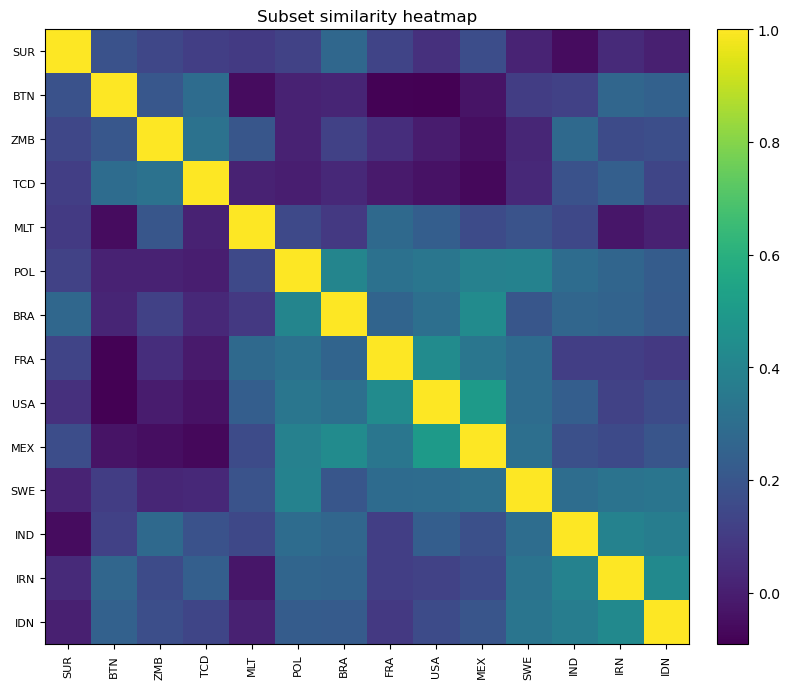

In [367]:
plot_similarity_subset(fused_year[2019],
                       countries=[
    "FRA",  # France (Western Europe, large EU country)
    "POL",  # Poland (Eastern Europe, post-communist)
    "SWE",  # Sweden (Nordic social democracy)
    "IND",  # India (South Asia, huge democracy)
    "IRN",  # Iran (Middle East, theocracy)
    "IDN",  # Indonesia (Southeast Asia, largest Muslim-majority country)
    "ZMB",  # Zambia (Sub-Saharan Africa, developing economy)
    "TCD",  # Chad (Sahel region, fragile state)
    "USA",  # United States (North America, developed democracy)
    "BRA",  # Brazil (Latin America’s largest economy)
    "MEX",  # Mexico (middle-income, NAFTA region)
    "BTN",  # Bhutan (small Himalayan kingdom)
    "MLT",  # Malta (tiny EU island state)
    "SUR",  # Suriname (small South American country)
],id_type="ISO3", cluster=True, show_every=1, tick_fontsize=8)


In [368]:

def plot_similarity_graph_from_smoothed(smoothed, year, title,
                                        method="topk", k=5, sim_threshold=0.5, max_edges=500,
                                        layout="spring", node_size=30,
                                        with_labels=False, seed=42, figsize=(8,6),
                                        color_by_continent=True):
    bundle = smoothed[year]
    S = np.array(bundle["S"], dtype=float)
    nodes_un = [str(x) for x in bundle["nodes"]]
    N = len(nodes_un)
    if N == 0:
        raise ValueError("Empty node list for this year.")
    if S.shape != (N, N):
        raise ValueError("S shape does not match nodes length.")
    np.fill_diagonal(S, 0.0)

    # --- sparsify ---
    keep = set()
    if method == "topk":
        for i in range(N):
            row = S[i]
            if np.all(row == 0): continue
            top_idx = np.argsort(-row)[:k]
            for j in top_idx:
                if row[j] > 0:
                    keep.add(tuple(sorted((i, j))))
    elif method == "threshold":
        idx_i, idx_j = np.where(S >= sim_threshold)
        for i, j in zip(idx_i, idx_j):
            if i != j:
                keep.add(tuple(sorted((i, j))))
    else:
        raise ValueError("method must be 'topk' or 'threshold'")

    keep = list(keep)
    keep.sort(key=lambda ij: S[ij[0], ij[1]], reverse=True)
    if max_edges and len(keep) > max_edges:
        keep = keep[:max_edges]

    # --- build graph ---
    G = nx.Graph()
    labels_iso3 = coco.convert(nodes_un, src="UNnumeric", to="ISO3")
    labels_cont = coco.convert(nodes_un, src="UNnumeric", to="continent")

    for n_un, n_iso, cont in zip(nodes_un, labels_iso3, labels_cont):
        G.add_node(n_un, label=n_iso, continent=cont)

    for i, j in keep:
        w = float(S[i, j])
        if w > 0:
            G.add_edge(nodes_un[i], nodes_un[j], weight=w)

    # --- choose layout ---
    if layout == "spring":
        pos = nx.spring_layout(G, weight="weight", seed=seed)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G, weight="weight")
    elif layout == "spectral":
        pos = nx.spectral_layout(G)
    else:
        raise ValueError("layout must be 'spring', 'kamada_kawai', or 'spectral'")

    # edge widths scaled
    weights = np.array([d["weight"] for _,_,d in G.edges(data=True)]) if G.number_of_edges() else np.array([])
    if weights.size:
        w_min, w_max = weights.min(), weights.max()
        if np.isclose(w_min, w_max):
            widths = np.full_like(weights, 1.0, dtype=float)
        else:
            widths = 0.5 + 3.0 * (weights - w_min) / (w_max - w_min)
    else:
        widths = []

    # --- color mapping by continent ---
    if color_by_continent:
        continents = sorted(set(nx.get_node_attributes(G, "continent").values()))
        cmap = plt.get_cmap("tab10")  # up to 10 distinct colors
        cont2col = {c: cmap(i % 10) for i, c in enumerate(continents)}
        node_colors = [cont2col[G.nodes[n]["continent"]] for n in G.nodes]
    else:
        node_colors = "skyblue"

    # --- draw ---
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=list(widths), alpha=1)
    if with_labels:
        draw_labels = {n: G.nodes[n]["label"] for n in G.nodes}
        nx.draw_networkx_labels(G, pos, labels=draw_labels, font_size=6)

    if color_by_continent:
        # legend
        for c, col in cont2col.items():
            plt.scatter([], [], c=[col], label=c)
        plt.legend(title="Continent", fontsize=8, title_fontsize=9, loc="best")

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return G



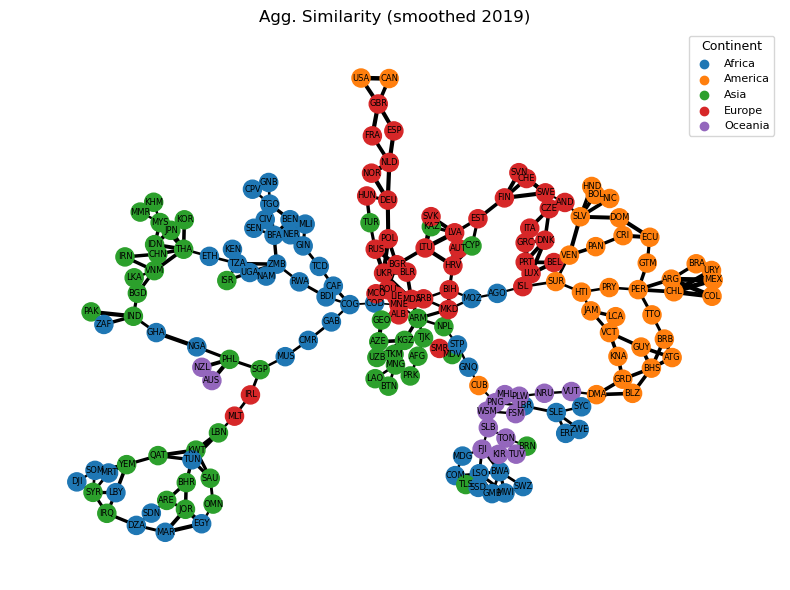

In [369]:
G = plot_similarity_graph_from_smoothed(
    smoothed, year=2019, method="topk", k=2, max_edges=None,
    layout="kamada_kawai", node_size=170, with_labels=True, color_by_continent=True, title="Agg. Similarity (smoothed 2019)"
)

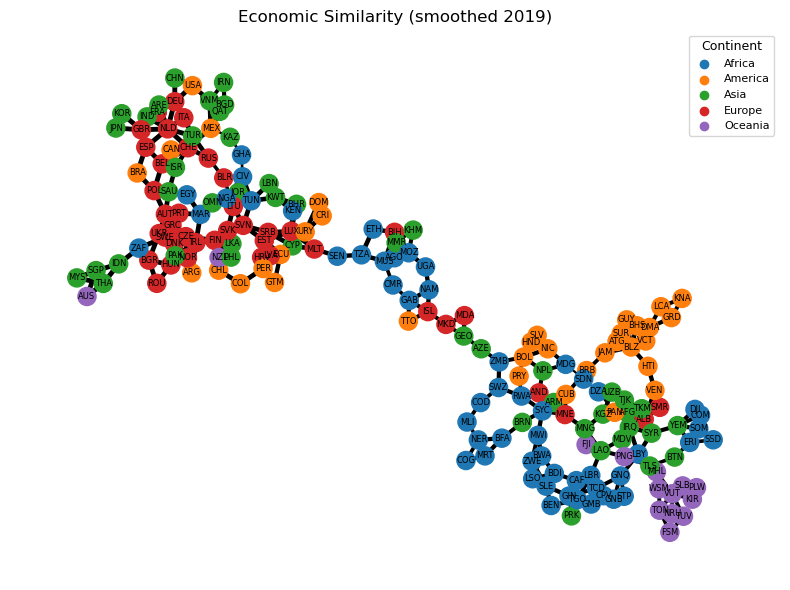

In [370]:
G = plot_similarity_graph_from_smoothed(
    temporal_fuse(S_by_layer["economic"], half_life=2, window=5), year=2019, method="topk", k=2, max_edges=None,
    layout="kamada_kawai", node_size=170, with_labels=True, color_by_continent=True,
    title="Economic Similarity (smoothed 2019)"
)

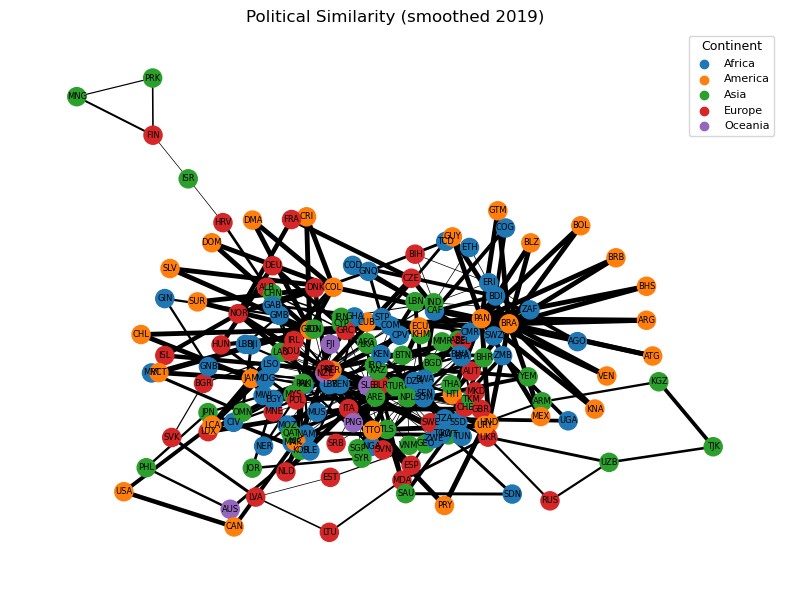

In [371]:
G = plot_similarity_graph_from_smoothed(
    temporal_fuse(S_by_layer["political"], half_life=2, window=5), year=2019, method="topk", k=2, max_edges=None,
    layout="kamada_kawai", node_size=170, with_labels=True, color_by_continent=True,
    title="Political Similarity (smoothed 2019)"
)

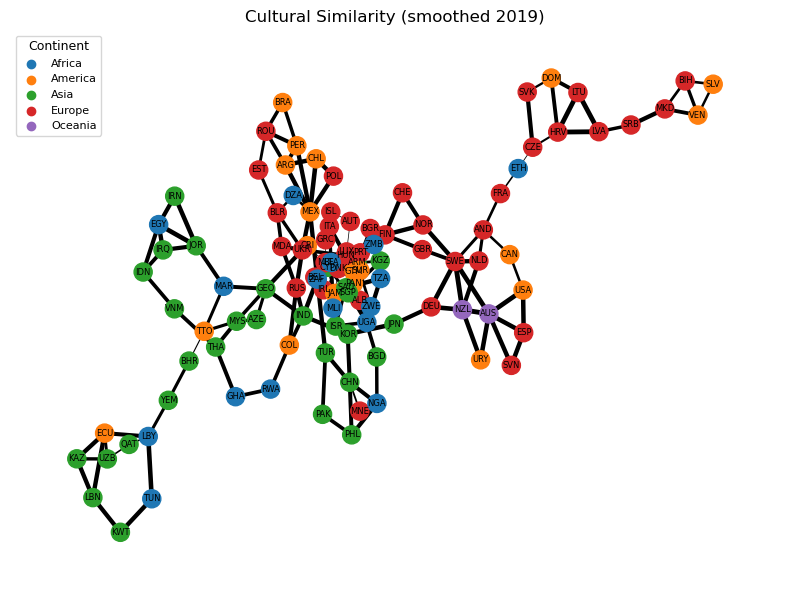

In [372]:
G = plot_similarity_graph_from_smoothed(
    temporal_fuse(S_by_layer["cultural"], half_life=2, window=5), year=2019, method="topk", k=2, max_edges=None,
    layout="kamada_kawai", node_size=170, with_labels=True, color_by_continent=True,
    title="Cultural Similarity (smoothed 2019)"
)

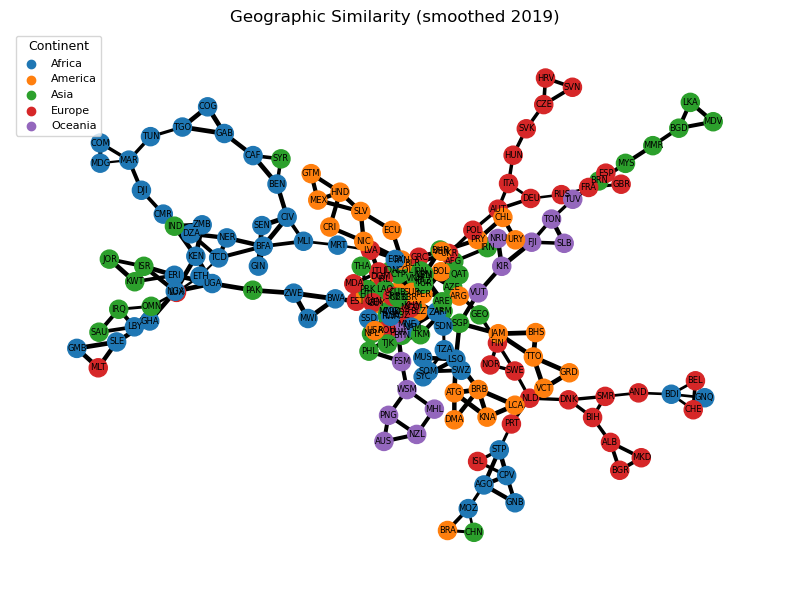

In [373]:
G = plot_similarity_graph_from_smoothed(
    temporal_fuse(S_by_layer["geographic"], half_life=2, window=5), year=2019, method="topk", k=2, max_edges=None,
    layout="kamada_kawai", node_size=170, with_labels=True, color_by_continent=True,
    title="Geographic Similarity (smoothed 2019)"
)

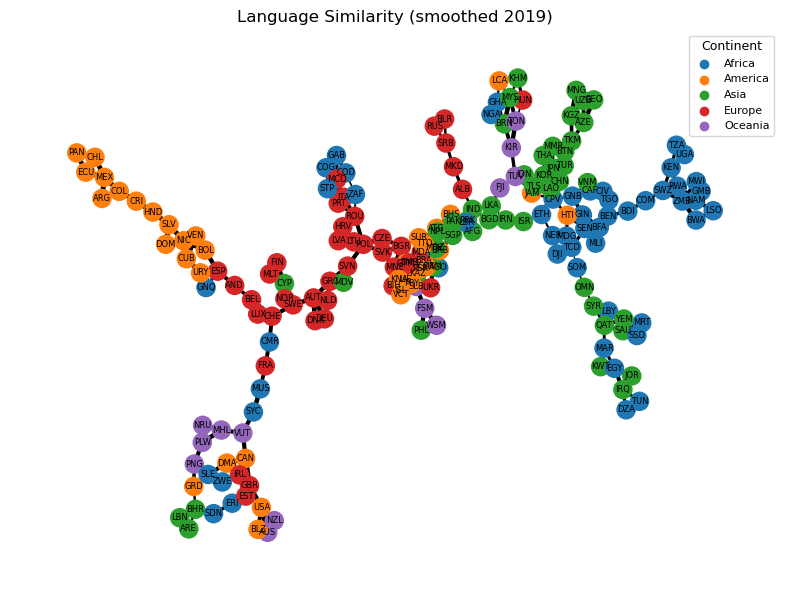

In [374]:
G = plot_similarity_graph_from_smoothed(
    temporal_fuse(S_by_layer["language"], half_life=2, window=5), year=2019, method="topk", k=2, max_edges=None,
    layout="kamada_kawai", node_size=170, with_labels=True, color_by_continent=True,
    title="Language Similarity (smoothed 2019)"
)

### Patterns of Inequality

In [375]:
df_gini

,country,year,gini
0,ABW,2000,NaN
1,AFG,2000,NaN
2,AGO,2000,51.9
3,ALB,2000,NaN
4,AND,2000,NaN
...,...,...,...
4963,XKX,2022,NaN
4964,YEM,2022,NaN
4965,ZAF,2022,NaN
4966,ZMB,2022,51.5


In [401]:
df_avg = df_gini.groupby("country", as_index=False)["gini"].mean()
df_avg.rename(columns={"gini": "avg_gini"}, inplace=True)
df_avg

,country,avg_gini
0,ABW,NaN
1,AFG,NaN
2,AGO,48.633333
3,ALB,31.372727
4,AND,NaN
...,...,...
211,XKX,34.687500
212,YEM,35.700000
213,ZAF,62.400000
214,ZMB,51.716667


In [414]:
import plotly.express as px

gini_min = df_avg["avg_gini"].min()
gini_max = df_avg["avg_gini"].max()
q1 = df_avg["avg_gini"].quantile(0.25)
median = df_avg["avg_gini"].quantile(0.5)
q3 = df_avg["avg_gini"].quantile(0.75)

fig = px.choropleth(
    df_avg,
    locations="country",          # expects ISO-3 codes
    color="avg_gini",
    color_continuous_scale="RdYlGn_r",  # or "RdYlGn" for diverging
    projection="natural earth"
)
fig.update_layout(
    width=1000,   # pixels
    height=600,
    font=dict(
        family="DejaVu Sans",   # closest to matplotlib default
        size=14,                # typical matplotlib axis label size
        color="black"
    ),
    title=dict(
        text="Average Gini by Country (2000-2022)",
        x=0.5,                # 0 = left, 0.5 = center, 1 = right
        xanchor="center",     
        yanchor="top",
        font=dict(
            family="Arial",
            size=18,
            color="black"
        )
    ),
    coloraxis_colorbar=dict(
        title="Avg Gini",
        tickvals=[gini_min, q1, median, q3, gini_max],
        ticktext=[
            f"Min: {gini_min:.1f}",
            f"Q1: {q1:.1f}",
            f"Median: {median:.1f}",
            f"Q3: {q3:.1f}",
            f"Max: {gini_max:.1f}"
        ],
        ticks="outside"
    )
)
fig.show()


### Visualizing missing data in Gini

In [422]:
mat = df_gini.pivot_table(index="country", columns="year", values="gini", aggfunc="mean")
mat = mat.reindex(mat.isna().mean(axis=1).sort_values(ascending=False).index)

In [423]:
# 2) Color limits for consistency
vmin = np.nanpercentile(mat.values, 2)   # robust to outliers
vmax = np.nanpercentile(mat.values, 98)

In [434]:
import plotly.graph_objects as go
fig = go.Figure(
    data=go.Heatmap(
        z=mat.values,
        x=mat.columns.astype(str),
        y=mat.index.astype(str),
        colorscale="RdYlGn_r",
        zmin=np.nanpercentile(mat.values, 2),
        zmax=np.nanpercentile(mat.values, 98),
        colorbar=dict(title="Gini"),
        xgap=1, ygap=1,             # ✅ creates tile borders
        hovertemplate="<b>%{y}</b> — %{x}<br>Gini: %{z:.1f}<extra></extra>"
    )
)

fig.update_layout(
    title=dict(text="Gini Availability by Country & Year", x=0.5),
    width=1100, height=800,
    paper_bgcolor="white", plot_bgcolor="white",
    font=dict(family="Arial", size=12, color="black"),
    margin=dict(l=10, r=10, t=60, b=10)
)
fig.update_yaxes(showticklabels=False)

fig.show()

### Graph Similarity

In [22]:
layer_names = ["geographic", "political", "cultural", "language", "economic"]
SRC_COL = "country_id_a"       # edge source country id
DST_COL = "country_id_b"       # edge target country id
YEAR_COL = "year"     # year column for nodes/edges
NODE_COL="country_id"
WEIGHT_COL = None     # set to e.g. "weight" if weighted graphs
DIRECTED = False      # set True if your graphs are directed
SPECTRAL_K = 20       # how many smallest eigenvalues to compare (top-k)
USE_NODE_UNION_FOR_SPECTRAL = True  # union vs intersection alignment
USE_NODE_INTERSECTION_FOR_EDGE = True

In [25]:
assert len(edges) == len(nodes), "edges and nodes must be same length"
if len(layer_names) != len(edges):
    layer_names = [f"layer_{i}" for i in range(len(edges))]

def _to_undirected(df_e: pd.DataFrame) -> pd.DataFrame:
    a = df_e[[SRC_COL, DST_COL, YEAR_COL] + ([WEIGHT_COL] if WEIGHT_COL else [])].copy()
    # canonical (min, max) endpoints, drop duplicates per year
    s = a[SRC_COL].where(a[SRC_COL] <= a[DST_COL], a[DST_COL])
    t = a[DST_COL].where(a[SRC_COL] <= a[DST_COL], a[SRC_COL])
    a[SRC_COL], a[DST_COL] = s, t
    a = a.drop_duplicates([SRC_COL, DST_COL, YEAR_COL])
    return a

# Normalize input (copy, enforce undirected if needed)
E_layers = []
N_layers = []
years_by_layer = []
for i in range(len(edges)):
    E = edges[i].copy()
    N = nodes[i].copy()
    need_e = {SRC_COL, DST_COL, YEAR_COL}
    need_n = {NODE_COL, YEAR_COL}
    missing_e = need_e - set(E.columns)
    missing_n = need_n - set(N.columns)
    if missing_e: raise ValueError(f"{layer_names[i]} edges missing: {missing_e}")
    if missing_n: raise ValueError(f"{layer_names[i]} nodes missing: {missing_n}")
    if WEIGHT_COL and WEIGHT_COL not in E.columns:
        raise ValueError(f"{layer_names[i]} expected weight column '{WEIGHT_COL}'")
    if not DIRECTED:
        E = _to_undirected(E)
    # coerce to str node ids and int years
    E[SRC_COL] = E[SRC_COL].astype(str)
    E[DST_COL] = E[DST_COL].astype(str)
    N[NODE_COL] = N[NODE_COL].astype(str)
    E[YEAR_COL] = E[YEAR_COL].astype(int)
    N[YEAR_COL] = N[YEAR_COL].astype(int)
    E_layers.append(E)
    N_layers.append(N)
    years_by_layer.append(set(pd.unique(pd.concat([E[YEAR_COL], N[YEAR_COL]], ignore_index=True))))


In [26]:
def build_graph(nodes, edges_df):
    G = nx.DiGraph() if DIRECTED else nx.Graph()
    G.add_nodes_from(nodes)
    if WEIGHT_COL:
        for r in edges_df.itertuples(index=False):
            G.add_edge(getattr(r, SRC_COL), getattr(r, DST_COL), weight=float(getattr(r, WEIGHT_COL)))
    else:
        for r in edges_df.itertuples(index=False):
            G.add_edge(getattr(r, SRC_COL), getattr(r, DST_COL))
    return G


def build_year_graph(i, year, node_set=None):
    E = E_layers[i]
    N = N_layers[i]
    e = E[E[YEAR_COL] == year][[SRC_COL, DST_COL] + ([WEIGHT_COL] if WEIGHT_COL else [])]
    n = set(N[N[YEAR_COL] == year][NODE_COL].tolist())
    nodes = set(node_set) if node_set is not None else n
    if not nodes:  # ensure we can build empty graph safely
        return nx.DiGraph() if DIRECTED else nx.Graph()
    e = e[e[SRC_COL].isin(nodes) & e[DST_COL].isin(nodes)]
    return build_graph(nodes, e)


In [33]:
# ---------- Similarity measures ----------
def edge_jaccard(G, H):
    def Eset(X):
        return set(X.edges()) if X.is_directed() else {tuple(sorted(e)) for e in X.edges()}
    EG, EH = Eset(G), Eset(H)
    u = EG | EH
    return len(EG & EH) / len(u) if u else 1.0

def degree_wasserstein(G, H):
    dG = [d for _, d in G.degree()]
    dH = [d for _, d in H.degree()]
    return float(wasserstein_distance(dG, dH)) if (dG or dH) else 0.0

def _norm_lap_smallest_k(G, node_order, k):
    """
    Robustly compute the k smallest eigenvalues of the normalized Laplacian.
    Handles tiny/disconnected graphs and falls back to dense if ARPACK fails.
    """
    n = len(node_order)
    if n == 0:
        return np.array([])
    if n == 1:
        # Laplacian is [0]; spectrum is [0]
        return np.array([0.0])[:min(k, 1)]
    # Build adjacency in fixed order
    idx = {n_: i for i, n_ in enumerate(node_order)}
    rows, cols, data = [], [], []
    for u, v, attr in G.edges(data=True):
        i = idx.get(u); j = idx.get(v)
        if i is None or j is None:
            continue
        w = float(attr.get("weight", 1.0))
        rows += [i, j]; cols += [j, i]; data += [w, w]
    A = coo_matrix((data, (rows, cols)), shape=(n, n)).tocsr()

    # Normalized Laplacian: L = I - D^{-1/2} A D^{-1/2}
    deg = np.array(A.sum(axis=1)).ravel()
    with np.errstate(divide="ignore"):
        d_inv_sqrt = np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0)
    Dinv = csr_matrix((d_inv_sqrt, (np.arange(n), np.arange(n))), shape=(n, n))
    I = csr_matrix(np.eye(n))
    L = I - Dinv @ A @ Dinv

    # Choose a safe k (ARPACK requires k < n)
    k_eff = max(1, min(int(k), n - 1))

    # For very small n, use dense directly
    if n <= 50:
        evals = np.linalg.eigvalsh(L.toarray())
        return np.sort(evals)[:k_eff]

    # Try ARPACK, then fall back to dense if it complains
    try:
        # Slightly larger Krylov subspace often helps convergence
        ncv = min(n, max(2 * k_eff + 1, 20))
        evals = eigsh(L, k=k_eff, which="SM", return_eigenvectors=False, ncv=ncv, tol=1e-6, maxiter=2000)
        return np.sort(evals)
    except ArpackError:
        evals = np.linalg.eigvalsh(L.toarray())
        return np.sort(evals)[:k_eff]

def spectral_distance(G, H, node_order, k):
    lamG = _norm_lap_smallest_k(G, node_order, k)
    lamH = _norm_lap_smallest_k(H, node_order, k=len(lamG) if len(lamG) else k)
    m = max(len(lamG), len(lamH))
    lamG = np.pad(lamG, (0, m - len(lamG)))
    lamH = np.pad(lamH, (0, m - len(lamH)))
    return float(np.linalg.norm(lamG - lamH))

In [34]:
# ---------- Cross-layer similarity per year ----------
pair_rows = []
pair_indices = list(combinations(range(len(layer_names)), 2))

# Use years present in ALL layers; for pairwise years, change to intersection per pair
years_all = sorted(set.intersection(*years_by_layer))

for y in years_all:
    for i, j in pair_indices:
        # Node alignment
        nodes_i = set(N_layers[i][N_layers[i][YEAR_COL] == y][NODE_COL])
        nodes_j = set(N_layers[j][N_layers[j][YEAR_COL] == y][NODE_COL])
        inter = nodes_i & nodes_j
        union = nodes_i | nodes_j

        Gi_edge = build_year_graph(i, y, inter if USE_NODE_INTERSECTION_FOR_EDGE else union)
        Gj_edge = build_year_graph(j, y, inter if USE_NODE_INTERSECTION_FOR_EDGE else union)

        align_nodes_spec = sorted(union if USE_NODE_UNION_FOR_SPECTRAL else inter)
        Gi_spec = build_year_graph(i, y, align_nodes_spec)
        Gj_spec = build_year_graph(j, y, align_nodes_spec)

        pair_rows.append({
            "year": y,
            "layer_a": layer_names[i],
            "layer_b": layer_names[j],
            "edge_jaccard": edge_jaccard(Gi_edge, Gj_edge),
            "degree_wasserstein": degree_wasserstein(Gi_edge, Gj_edge),
            "spectral_distance": spectral_distance(Gi_spec, Gj_spec, align_nodes_spec, k=SPECTRAL_K),
            "n_nodes_intersection": len(inter),
            "n_nodes_union": len(union),
            "n_edges_a": Gi_edge.number_of_edges(),
            "n_edges_b": Gj_edge.number_of_edges(),
        })

df_crosslayer = pd.DataFrame(pair_rows).sort_values(["year", "layer_a", "layer_b"]).reset_index(drop=True)


In [35]:
# ---------- Temporal similarity within each layer (adjacent years) ----------
temporal_rows = []
for i, name in enumerate(layer_names):
    yrs = sorted(years_by_layer[i])
    for y1, y2 in zip(yrs[:-1], yrs[1:]):
        nodes_1 = set(N_layers[i][N_layers[i][YEAR_COL] == y1][NODE_COL])
        nodes_2 = set(N_layers[i][N_layers[i][YEAR_COL] == y2][NODE_COL])
        inter = nodes_1 & nodes_2
        union = nodes_1 | nodes_2

        G1_edge = build_year_graph(i, y1, inter if USE_NODE_INTERSECTION_FOR_EDGE else union)
        G2_edge = build_year_graph(i, y2, inter if USE_NODE_INTERSECTION_FOR_EDGE else union)

        align_nodes_spec = sorted(union if USE_NODE_UNION_FOR_SPECTRAL else inter)
        G1_spec = build_year_graph(i, y1, align_nodes_spec)
        G2_spec = build_year_graph(i, y2, align_nodes_spec)

        temporal_rows.append({
            "layer": name,
            "year_a": y1,
            "year_b": y2,
            "edge_jaccard": edge_jaccard(G1_edge, G2_edge),
            "degree_wasserstein": degree_wasserstein(G1_edge, G2_edge),
            "spectral_distance": spectral_distance(G1_spec, G2_spec, align_nodes_spec, k=SPECTRAL_K),
            "n_nodes_intersection": len(inter),
            "n_nodes_union": len(union),
            "n_edges_a": G1_edge.number_of_edges(),
            "n_edges_b": G2_edge.number_of_edges(),
        })

df_temporal = pd.DataFrame(temporal_rows).sort_values(["layer", "year_a", "year_b"]).reset_index(drop=True)
